<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/Med/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [1]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Mounted at /content/drive


### **Première exploration des données**

**Visualisation des données**

In [2]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [3]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [5]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [6]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [7]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [8]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


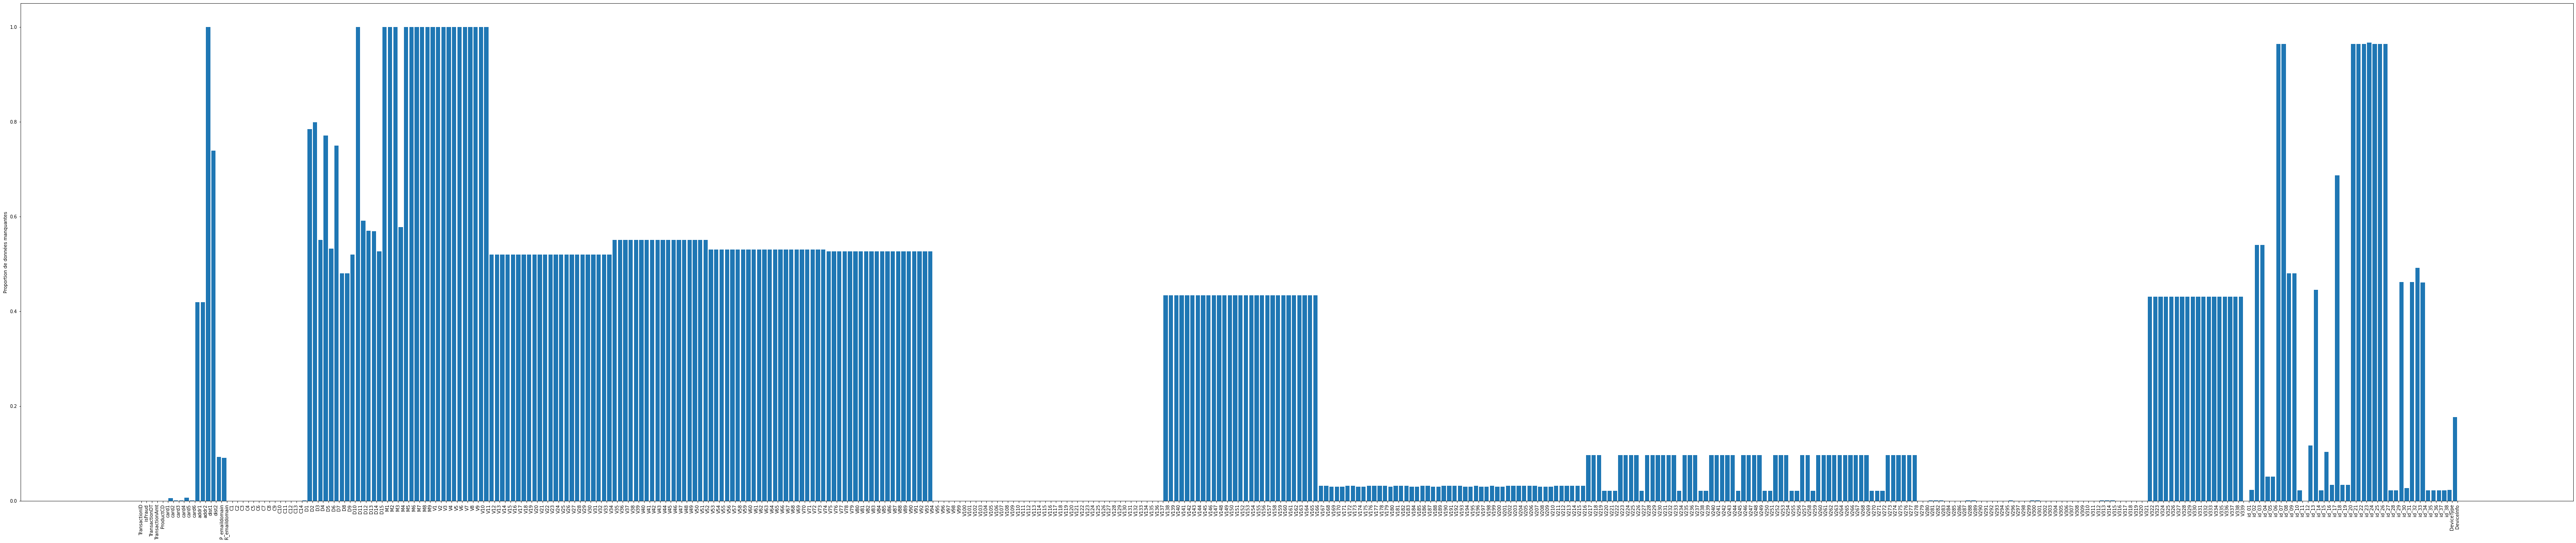

In [9]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [10]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

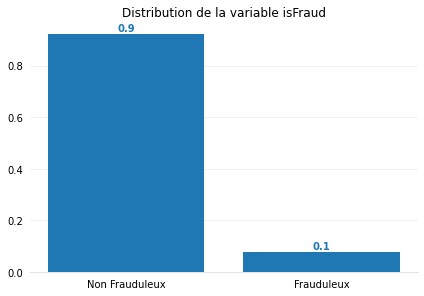

In [11]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [12]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

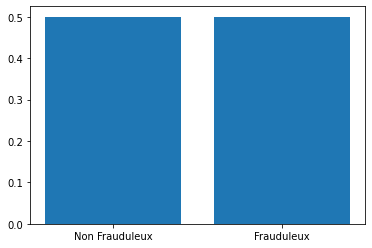

In [13]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

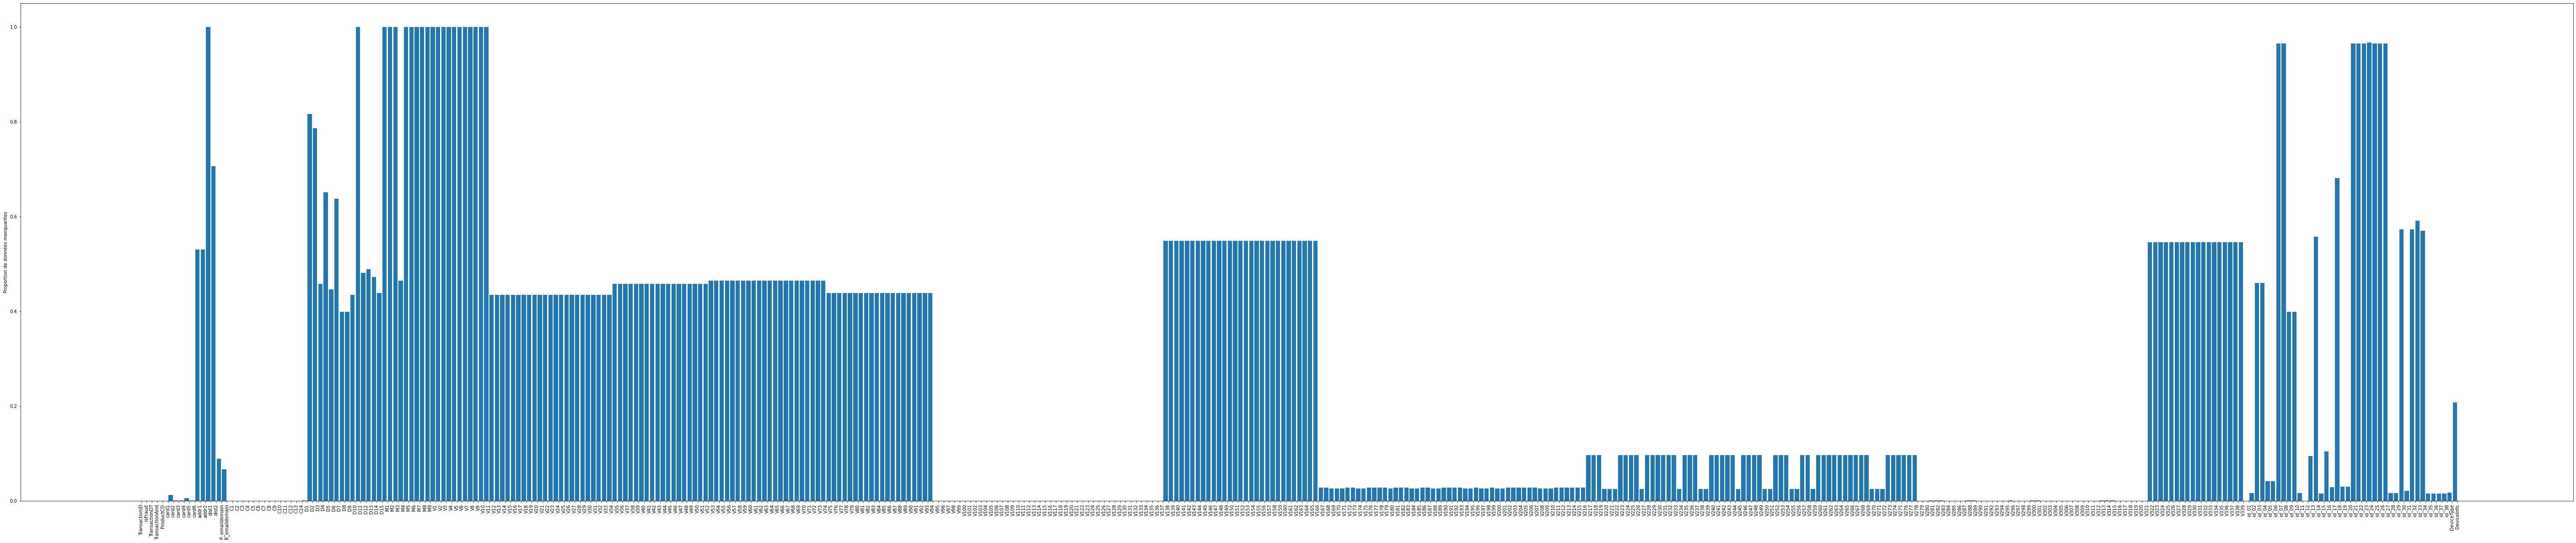

In [14]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

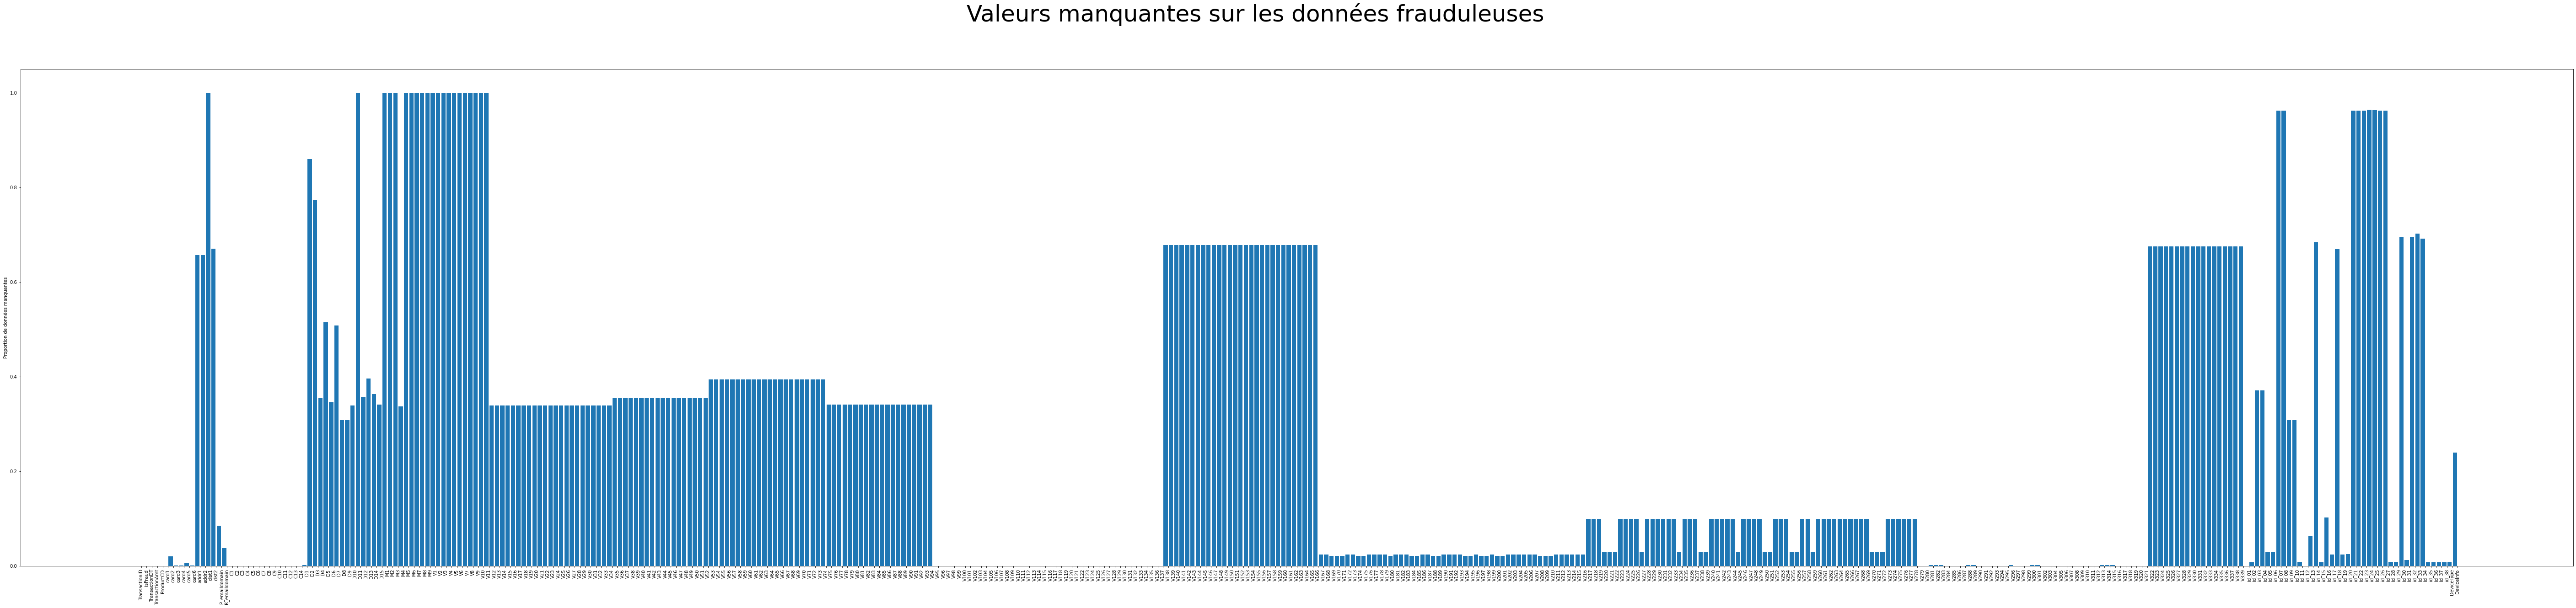

In [15]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

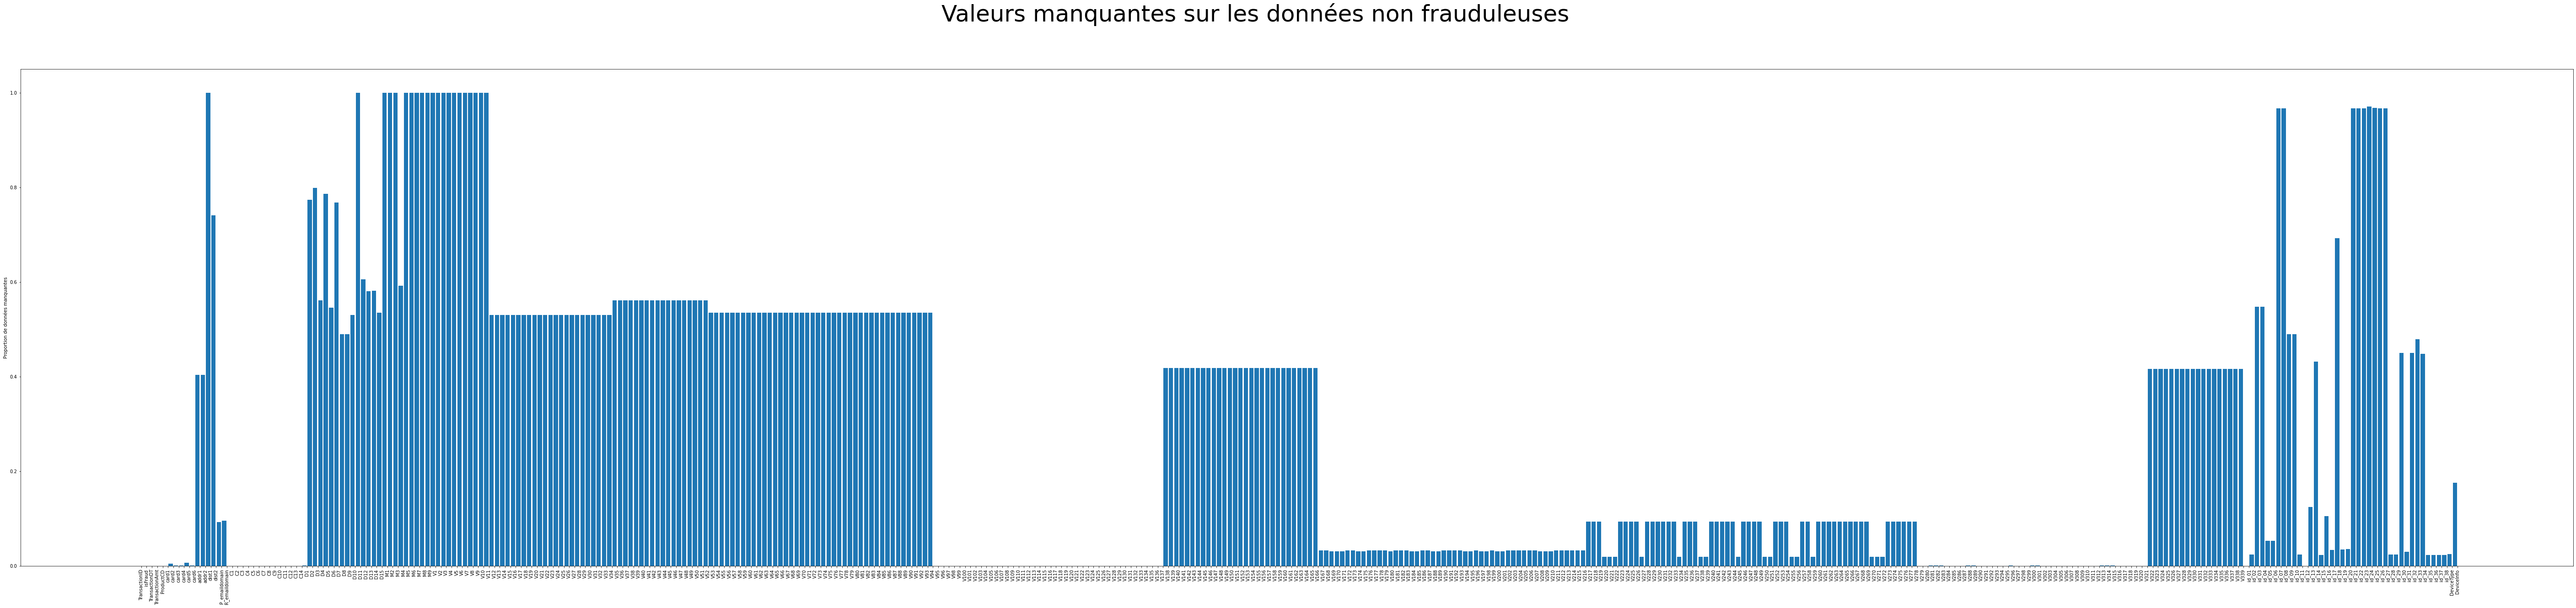

In [16]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [17]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


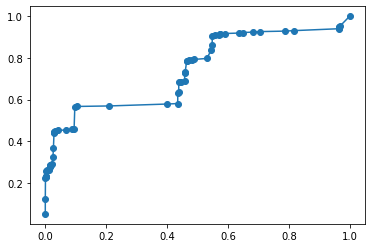

In [18]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

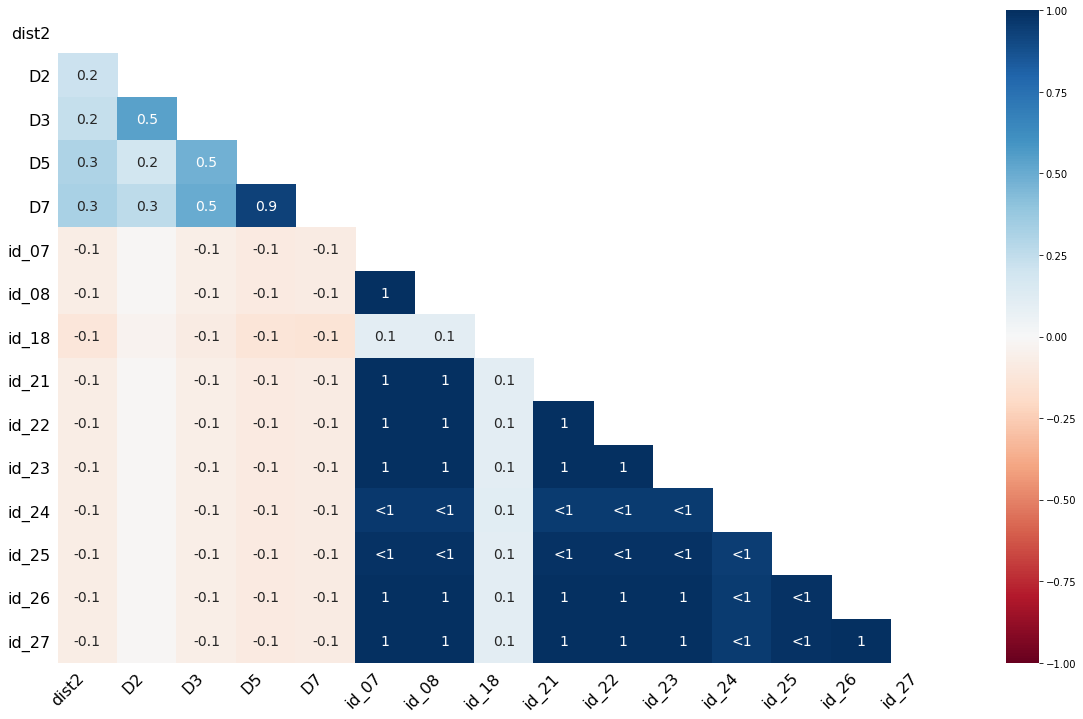

In [19]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [20]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes  
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

Valeur manquante en utilisant  Multivariate Imputation by Chained Equation (MICE) [Mice](https://www.jstatsoft.org/article/view/v045i03)

In [56]:
from impyute.imputation.cs import mice
from datetime import datetime
start_time = datetime.now()
train_imputed1=mice(train_work.select_dtypes(exclude='object').values)
end_time = datetime.now()
time_mice=end_time-start_time

KeyboardInterrupt: ignored

In [ ]:
train_imputed1

valeur manqante en utilisant KNN

In [ ]:
from sklearn.impute import KNNImputer
start_time=datetime.now()
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))
end_time=datetime.now()
time_knn=end_time-start_time

In [22]:
train_imputed

array([[2.9870490e+06, 0.0000000e+00, 8.7317000e+04, ..., 2.2500000e+02,
        2.5400000e+02, 5.0700000e+02],
       [2.9871300e+06, 0.0000000e+00, 8.8619000e+04, ..., 1.2100000e+02,
        4.1000000e+02, 1.4200000e+02],
       [2.9871450e+06, 0.0000000e+00, 8.8805000e+04, ..., 1.6600000e+02,
        3.5200000e+02, 2.1400000e+02],
       ...,
       [3.5773640e+06, 1.0000000e+00, 1.5807516e+07, ..., 2.2500000e+02,
        2.6600000e+02, 3.1500000e+02],
       [3.5773680e+06, 1.0000000e+00, 1.5807677e+07, ..., 1.6600000e+02,
        4.9200000e+02, 2.2500000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

**Comparaison des méthodes d'imputation des valeurs manquantes**

In [ ]:
print(time_mice)
print(time_KNN)

In [23]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987049.0,0.0,87317.0,3.595,12730.0,266.0,185.0,224.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,2.0,1.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,287959.0,1.0,-11.0,100.0,52.0,225.0,254.0,507.0,C,mastercard,credit,anonymous.com,anonymous.com,NotFound,New,NotFound,New,NotFound,chrome 62.0,F,F,T,T,desktop
1,2987130.0,0.0,88619.0,70.933,13329.0,569.0,117.0,226.0,2.0,6.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,75.887497,75.887497,75.887497,75.887497,75.887497,75.887497,75.887497,75.887497,75.887497,0.0,0.0000,0.0,0.0,0.0,0.0,-10.0,175789.0,0.0,0.0,100.0,52.0,121.0,410.0,142.0,C,visa,credit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 62.0,F,F,T,T,desktop
2,2987145.0,0.0,88805.0,100.000,8260.0,399.0,150.0,150.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,127488.0,2.0,-11.0,100.0,49.0,166.0,352.0,214.0,R,american express,credit,anonymous.com,anonymous.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,F,mobile
3,2987156.0,0.0,88965.0,50.000,3334.0,583.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,55836.0,0.0,0.0,100.0,52.0,166.0,542.0,489.0,R,visa,credit,comcast.net,comcast.net,NotFound,New,NotFound,New,NotFound,chrome 62.0,T,F,T,F,desktop
4,2987236.0,0.0,90149.0,30.000,10023.0,111.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,52546.0,0.0,0.0,100.0,49.0,166.0,390.0,549.0,H,visa,debit,yahoo.com,gmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577351.0,1.0,15807131.0,125.665,3289.0,176.0,185.0,224.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-20.0,190267.0,-5.0,-20.0,100.0,27.0,225.0,417.0,612.0,C,mastercard,credit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,chrome 66.0 for android,F,F,T,F,mobile
22632,3577354.0,1.0,15807171.0,125.665,14337.0,228.0,106.0,137.0,3.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-25.0,229668.0,-5.0,-20.0,100.0,27.0,225.0,417.0,612.0,C,visa,debit,gmail.com,gmail.com,NotFound,Found,Found,Found,Found,chrome 66.0 for android,F,F,T,

**categorical features**

C    12358
R     4437
H     4232
S     1609
Name: ProductCD, dtype: int64


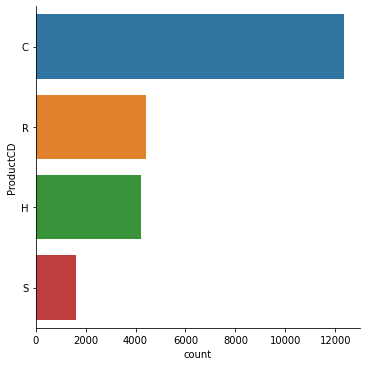

In [24]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                13959
mastercard           7304
american express      981
discover              366
NaN                    26
Name: card4, dtype: int64


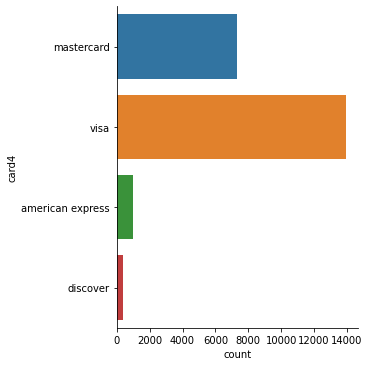

In [25]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12473
debit          10136
NaN               25
charge card        2
Name: card6, dtype: int64


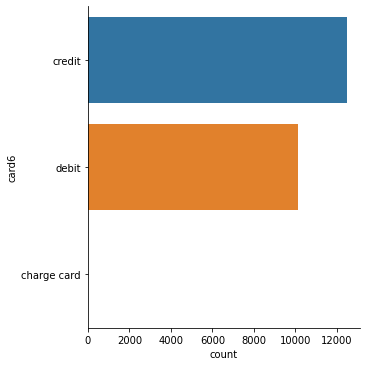

In [26]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

gmail.com           10347
hotmail.com          4037
anonymous.com        2111
NaN                  2016
yahoo.com            1440
outlook.com           580
aol.com               449
comcast.net           243
icloud.com            191
msn.com               104
yahoo.com.mx          102
live.com               89
outlook.es             86
live.com.mx            83
verizon.net            76
sbcglobal.net          65
me.com                 64
hotmail.es             50
mail.com               48
cox.net                41
att.net                40
mac.com                32
bellsouth.net          31
ymail.com              30
protonmail.com         28
hotmail.fr             26
web.de                 23
charter.net            22
optonline.net          19
earthlink.net          17
prodigy.net.mx         14
gmail                  12
hotmail.co.uk          12
yahoo.fr               11
gmx.de                 11
q.com                   7
suddenlink.net          6
rocketmail.com          6
yahoo.de    

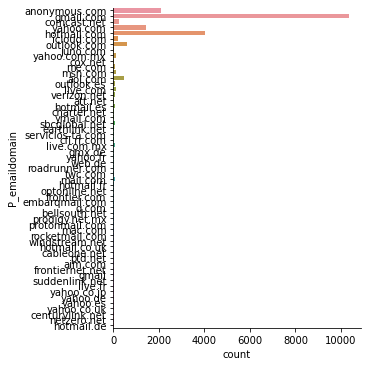

In [27]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

gmail.com           10782
hotmail.com          3982
anonymous.com        2224
yahoo.com            1526
NaN                  1519
outlook.com           574
aol.com               437
icloud.com            279
comcast.net           176
yahoo.com.mx          102
live.com              100
outlook.es             86
live.com.mx            86
me.com                 65
msn.com                64
mail.com               52
hotmail.es             50
cox.net                48
verizon.net            48
sbcglobal.net          44
protonmail.com         39
bellsouth.net          36
att.net                34
hotmail.fr             27
ymail.com              21
web.de                 21
mac.com                20
charter.net            15
earthlink.net          14
prodigy.net.mx         14
gmail                  13
optonline.net          12
hotmail.co.uk          12
yahoo.fr               11
gmx.de                 11
rocketmail.com         10
juno.com                9
frontier.com            7
yahoo.de    

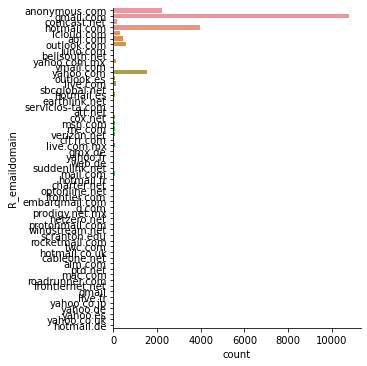

In [28]:
print(train_imputed['R_emaildomain'].value_counts(dropna=False))
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

NotFound    19671
Found        2965
Name: id_12, dtype: int64


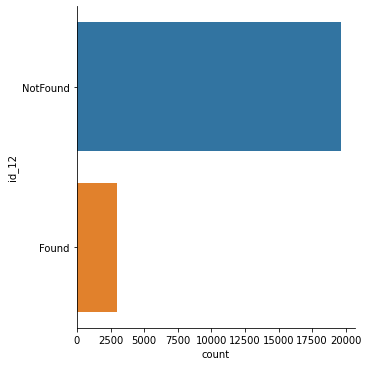

In [29]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12367
New         7910
Unknown     1992
NaN          367
Name: id_15, dtype: int64


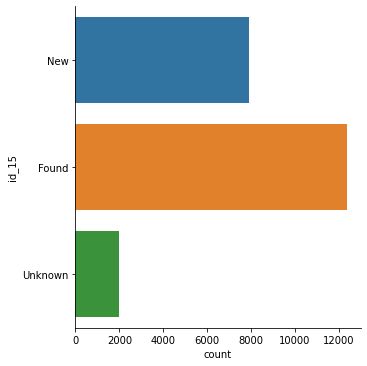

In [30]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12234
NotFound     8043
NaN          2359
Name: id_16, dtype: int64


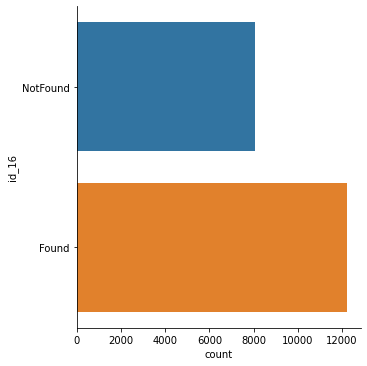

In [31]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13726
New       8538
NaN        372
Name: id_28, dtype: int64


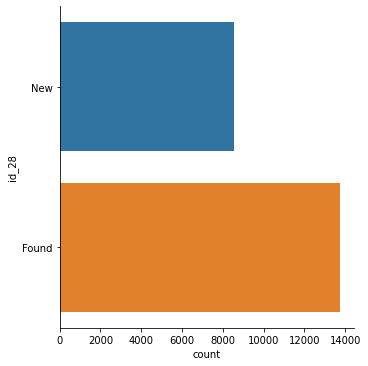

In [32]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13599
NotFound     8665
NaN           372
Name: id_29, dtype: int64


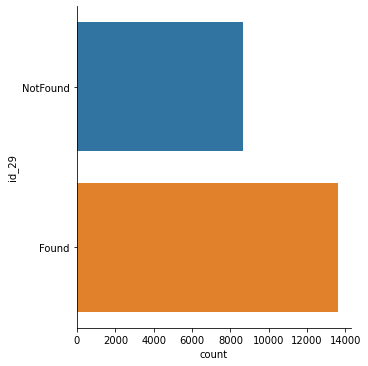

In [33]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

chrome 63.0                       3223
mobile safari generic             2030
mobile safari 11.0                1892
chrome 65.0                       1162
chrome 64.0                       1141
chrome generic                    1134
chrome 63.0 for android           1116
ie 11.0 for desktop                934
chrome 62.0                        933
safari generic                     914
chrome 64.0 for android            786
chrome 66.0                        725
chrome 65.0 for android            724
chrome 66.0 for android            493
NaN                                485
firefox 57.0                       437
edge 16.0                          435
mobile safari 10.0                 373
chrome 62.0 for android            335
chrome generic for android         215
edge 15.0                          201
firefox                            195
firefox 59.0                       166
samsung browser 6.2                165
firefox 58.0                       142
chrome 61.0 for android  

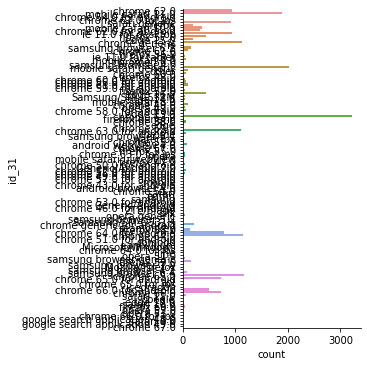

In [34]:
print(train_imputed['id_31'].value_counts(dropna=False))
sns.catplot(y='id_31',kind='count',data=train_imputed)

F      12553
T       9716
NaN      367
Name: id_35, dtype: int64


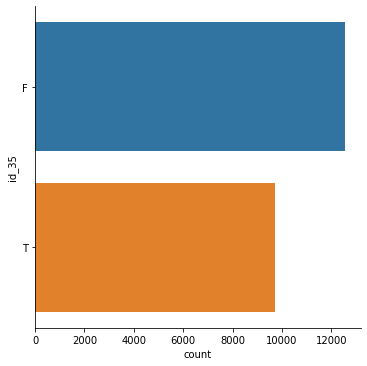

In [35]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21400
T        869
NaN      367
Name: id_36, dtype: int64


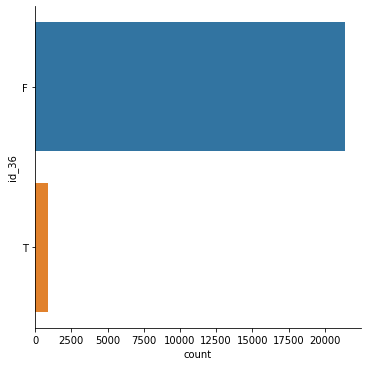

In [36]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17793
F       4476
NaN      367
Name: id_37, dtype: int64


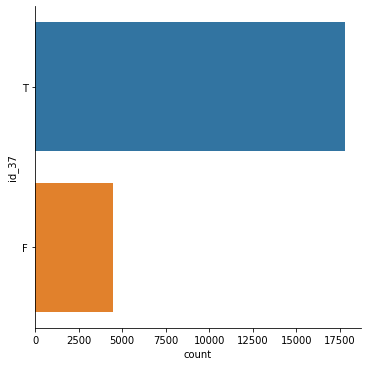

In [37]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12921
T       9348
NaN      367
Name: id_38, dtype: int64


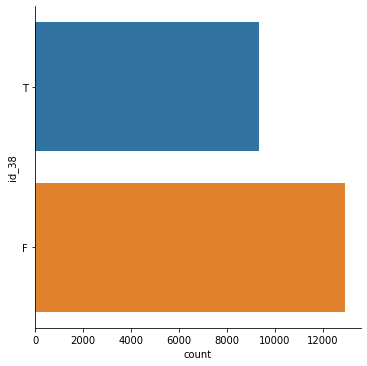

In [38]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12302
mobile      9939
NaN          395
Name: DeviceType, dtype: int64


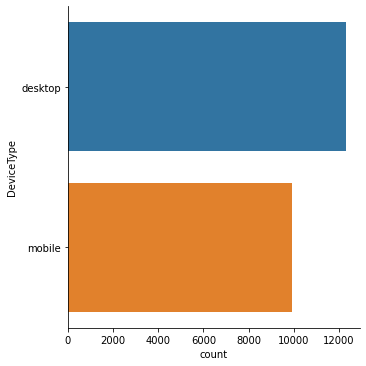

In [39]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)

**Logistic Regression avec les features numerique**

In [40]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [41]:
train1=train_imputed.drop(['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType'],axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)


In [42]:
start_time = datetime.now()
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time = datetime.now()
time_logit1=end_time-start_time

0.8443490442797931

**Feature importance**

Feature: TransactionID Score: 5.08322
Feature: TransactionDT Score: -4.69144
Feature: TransactionAmt Score: 0.46051
Feature: card1 Score: -0.11576
Feature: card2 Score: -0.13181
Feature: card3 Score: 0.30808
Feature: card5 Score: -0.05433
Feature: C1 Score: -2.40755
Feature: C2 Score: 2.72931
Feature: C3 Score: -0.76703
Feature: C4 Score: 1.14596
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.32377
Feature: C7 Score: -4.15417
Feature: C8 Score: 3.41071
Feature: C9 Score: 0.00000
Feature: C10 Score: 3.28292
Feature: C11 Score: 4.79040
Feature: C12 Score: -1.05690
Feature: C13 Score: -2.60881
Feature: C14 Score: -5.55606
Feature: D1 Score: -0.30205
Feature: V95 Score: 0.29749
Feature: V96 Score: -0.34969
Feature: V97 Score: -0.16520
Feature: V98 Score: -0.06616
Feature: V99 Score: 0.69510
Feature: V100 Score: 0.03496
Feature: V101 Score: 0.44757
Feature: V102 Score: -0.19702
Feature: V103 Score: -0.11594
Feature: V104 Score: -0.16396
Feature: V105 Score: -1.51490
Feature: V106 Score: 0.

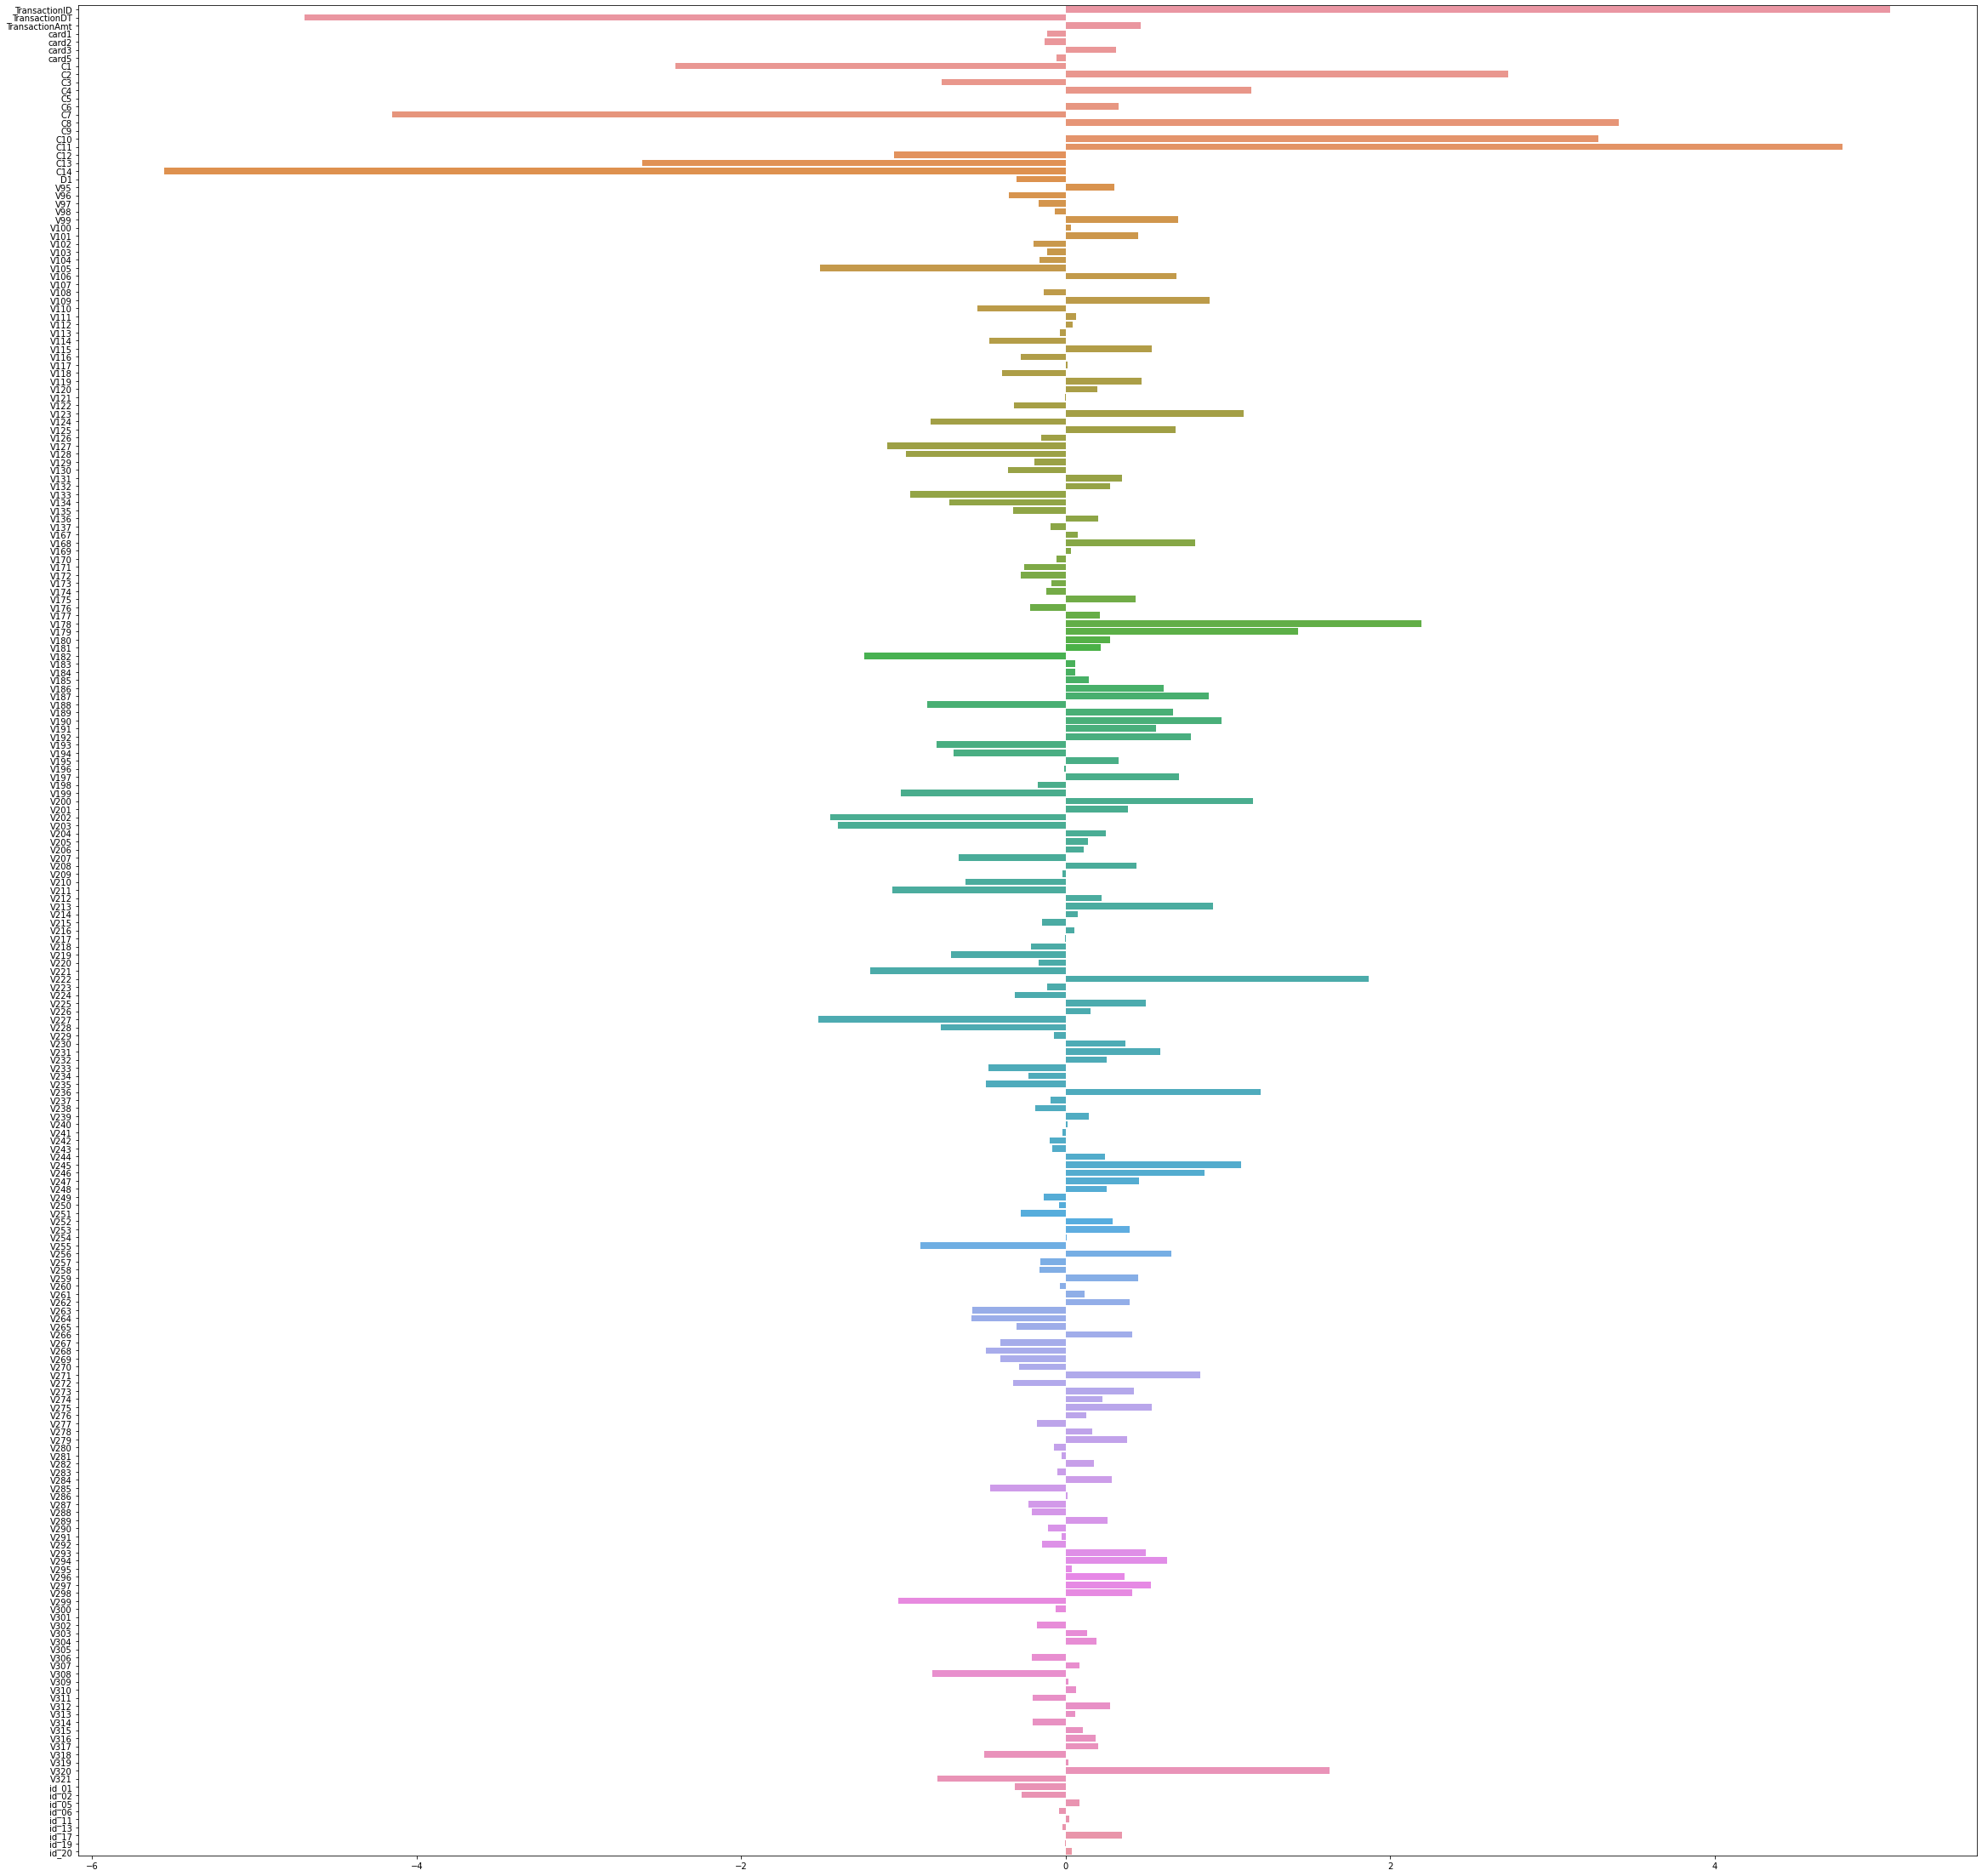

In [43]:
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [44]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="f1")
rfecv.fit(X_train_st,Y_train)
rfecv.transform(X_train_st)

KeyboardInterrupt: ignored

In [ ]:
rfecv.n_features_#Number of best features

In [ ]:
rfecv.ranking_

In [ ]:
rfecv.support_#which features to keep 

In [ ]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

**best 35 features**

Since crossvalidation is a random process and we can get different outputs for different imputations we fix a nombre of features to always take. From the graph below we can see that ~35 features is good enough.

In [ ]:
dictionnaire={}
best_35_features=[]
features_to_take=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==True:
    features_to_take.append(i)
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
#summarize feature importance
for i,v in enumerate(importance):
  if i in features_to_take:
    dictionnaire[i]= abs(v)
sortedDict = sorted(dictionnaire.items(), key=lambda x: x[1])
for j in range(1,36):
  best_35_features.append(sortedDict[-j][0])
for k in range(len(best_35_features)):
  best_35_features[k]=list(X_train.columns)[best_35_features[k]]
best_35_features


**Removing irrelevant features**

In [ ]:
#il faut q'on fixe un thresh hold q
l1=[]#liste des features sans imporatnace
for i in range(len(imp)):
  if imp[i]==0:
    l1.append(list(X_train.columns)[i])
X_train_q=X_train.drop(l1,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st_q=scaler.fit_transform(X_train_q)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st_q, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

**Logistic Regression avec toutes les features**

In [ ]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train_1=train_imputed.drop(sites,axis=1)
Y_train=train_1['isFraud'].astype('int')
X_train=train_1.drop('isFraud',axis=1)
X_train_full=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st_only_numerical=scaler.fit_transform(X_train)
X_train_full_st=pd.merge(pd.DataFrame(X_train_st_only_numerical),pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)

In [ ]:
start_time = datetime.now()
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_full_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_logit2=end_time-start_time

**Feature importance**

In [ ]:
logit.fit(X_train_full_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train_full.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train_full.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [ ]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="f1")
rfecv.fit(X_train_full_st,Y_train)
rfecv.transform(X_train_full_st)

In [ ]:
rfecv.n_features_

In [ ]:
rfecv.ranking_

In [ ]:
rfecv.support_#which features to keep 

In [ ]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train_full_st.columns)[i])
X_train_full_st_1=X_train_full_st.drop(pp,axis=1)
logit=LogisticRegression(C=2,random_state=42)
cv_scores = cross_val_score(logit, X_train_full_st_1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

**SVM**

svm tuning

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_full_st, y_train) 
print(grid.best_params_) 


In [ ]:
start_time = datetime.now()
Supoort_vector=SVC(C=0.1,gamma=0.01,kernel='rbf')
cv_scores = cross_val_score(Support_vector, X_train_full_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time = datetime.now()
time_SVM=end_time-start_time

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
start_time=datetime.now()
decision_tree_gini=DecisionTreeClassifier(criterion='gini',random_state=42)
cv_scores = cross_val_score(decision_tree_gini, X_train_full, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_decision_tree=end_time-start_time

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
start_time=datetime.now()
randomforest=RandomForestClassifier(random_state=0,n_jobs=-1,criterion="gini")
cv_scores = cross_val_score(randomforest, X_train_full, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_random_forest=end_time-start_time

**Boosting**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train_full,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_